# Formeln vom Manual

In [224]:
import numpy as np
import uncertainties as u
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties.umath import __all__
from uncertainties.umath import *
import uncertainties.unumpy as unp
import scipy.constants
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas # pip install Jinja2
import pint # pip install pint OR conda install pint
units = pint.UnitRegistry()
units.default_format = '~'
umean = u.wrap(np.mean)
ustd = u.wrap(np.std)
usin = u.wrap(np.sin)
no_unit = (units.m/units.m)
usquare = u.wrap(np.square)
import warnings
warnings.simplefilter("ignore")
cm = 1/2.54

def strip_units(np_arr):
    return np.array([(a.to_base_units().magnitude if type(a)!=float else a) for a in np_arr])

def extr_values(np_arr):
    return unp.nominal_values(np_arr)

def extr_sig(np_arr):
    return unp.std_devs(np_arr)

def errorbar_plot_with_linregress(X, Y, SIG_Y, errbarlabel='errbarlabel', xlabel='xlabel', ylabel='ylabel', errbarcolor='blue', linfitlabel='linfitlabel', nolinregress=False):
    result = scipy.stats.linregress(X, Y)
    #slope, intercept, rvalue, pvalue, sevalue, inteerr
    print("slope: ", result.slope)
    print("slope_err:", result.stderr)
    print("intercept: ", result.intercept)
    x_axis_spaced = np.linspace(np.min(X), np.max(X), 10)
    fig, ax = plt.subplots(1,1,figsize=(8*cm, 8*cm))
    #ax.plot(x,y,linestyle='-', color='red')
    if not nolinregress:
        ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'r--', label=linfitlabel)
    ax.errorbar(X, Y, yerr=SIG_Y, linestyle='', color=errbarcolor, capsize=3, label=errbarlabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_xlim([-1,1])
    #ax.set_ylim([-4,4])
    ax.legend(loc='upper left')
    plt.show()
    if not nolinregress:
        return u.ufloat(result.slope, result.stderr), u.ufloat(result.intercept, result.intercept_stderr) # (slope+=unc), (intercept+=unc)

# Formel (2)
# n'2(nu) = 1 + A/(nu0dash^2-nu^2)
# nu0dash, A sind Materialkonstanten
def n_squared_of_nu(nu, nu0dash, A):
    n_sq = 1 + A/(u.wrap(np.square)(nu0dash)-u.wrap(np.square)(nu))
    return n_sq

def n_squared_of_nu_squared(nu_squared, nu0dash, A):
    n_sq = 1 + A/(nu0dash**2-nu_squared)
    return n_sq

# Formel (2) und die Wurzel gezogen
def n_of_nu(nu, nu0dash, A):
    #n = u.wrap(np.sqrt)(n_squared_of_nu(nu, nu0dash,A))
    n = np.array([u.wrap(np.sqrt)(n_squared_of_nu(nu_i, nu0dash, A)) for nu_i in nu])
    return n

def n_of_phi_delta0(phi, delta0):
    left = usin((delta0 + phi)/2)
    right = usin(phi/2)
    eta = left/right
    return eta

# nu0dash, A sind Materialkonstanten
def f_of_nu_squared(nu_squared, nu0dash, A):
    denom = (n_squared_of_nu_squared(nu_squared, nu0dash, A)-1.0)
    f = 1/ np.array(strip_units([(d if np.abs(d) >= 0.0000001 else 0.0000001) for d in denom])) * no_unit
    return f

# used if n_squared is already known
def f_of_n_squared(n_squared):
    f = 1/(n_squared-1)
    return f

# calculate frequency from wavelength
def nu_of_lambda(lambda_, c0=scipy.constants.c*units.meter/units.s):
    return c0/lambda_

def delta0_of_A1_A2(A1, A2):
    return (A1 - A2)/2

# First Task: Determine $\varphi$
Measure both positions where the reflections of the slit image are observed: $A_{1}$, $A_{2}$. Then $\beta = A_{1} - A_{2}$. Make sure the signs are correct (can we take the absolute value?). Do this three times, so we get three $\beta$ values. Take the mean of $\beta$. Then $\varphi = \pi - \beta$.

In [225]:
A1_meas, A2_meas = np.genfromtxt(os.path.join(os.getcwd(), "task1_measure_phi_data.csv"), delimiter=',', skip_header=1, unpack=True)

A_meas_uncertainty_guess = 99.999 # TODO change this value
A_unit = units.rad
A1s = np.array([u.ufloat(a1, A_meas_uncertainty_guess) for a1 in A1_meas]) *A_unit
A2s = np.array([u.ufloat(a2, A_meas_uncertainty_guess) for a2 in A2_meas]) *A_unit

Betas = A1s - A2s
Betas_Std = np.std(extr_values(Betas))

Beta = umean(Betas)

# PRINT AND GENERATE LATEX
DF_TABLE_1 = pandas.DataFrame({"A1 [%s]"%(units.rad): A1s, "A2 []": A2s, r'$\beta$': Betas})
print("Table of Data:")
print(DF_TABLE_1, '\n')
print("Table latex:")
print(DF_TABLE_1.style.to_latex(column_format='|l|l|l|l|'), '\n')
print("Mean(beta)+=prop_unc_a: ", Beta, '\n')
print("Mean(beta)+=Std(betas):", u.ufloat(Beta.nominal_value,Betas_Std)*A_unit)

Beta_Result = Beta
if (Beta.std_dev < Betas_Std):
    Beta_Result = u.ufloat(Beta.nominal_value, Betas_Std)*A_unit
    print("Standard deviation of the betas was higher so this was taken instead of the propagation of the errors of measurement of A.")
else:
    Beta_Result = Beta
    print("Standard deviation of the betas was lower than the propagation of the errors of measurement of A. So the propagated error was taken.")

print("Beta End Result: ", Beta_Result)

Phi_Result = scipy.constants.pi*A_unit - Beta

print("Phi end result:", Phi_Result)




Table of Data:
          A1 [rad]            A2 []           $\beta$
0  (5.6+/-1.0)e+02  (7.8+/-1.0)e+02  (-2.1+/-1.4)e+02
1  (5.3+/-1.0)e+02  (9.8+/-1.0)e+02  (-4.4+/-1.4)e+02
2  (5.5+/-1.0)e+02  (8.8+/-1.0)e+02  (-3.3+/-1.4)e+02 

Table latex:
\begin{tabular}{|l|l|l|l|}
 & A1 [rad] & A2 [] & $\beta$ \\
0 & (5.6+/-1.0)e+02 & (7.8+/-1.0)e+02 & (-2.1+/-1.4)e+02 \\
1 & (5.3+/-1.0)e+02 & (9.8+/-1.0)e+02 & (-4.4+/-1.4)e+02 \\
2 & (5.5+/-1.0)e+02 & (8.8+/-1.0)e+02 & (-3.3+/-1.4)e+02 \\
\end{tabular}
 

Mean(beta)+=prop_unc_a:  (-3.3+/-0.8)e+02 rad 

Mean(beta)+=Std(betas): (-3.3+/-0.9)e+02 rad
Standard deviation of the betas was higher so this was taken instead of the propagation of the errors of measurement of A.
Beta End Result:  (-3.3+/-0.9)e+02 rad
Phi end result: (3.3+/-0.8)e+02 rad


# Second Task{Determine $\eta$ and the dispersion curve.}
For various wavelengths of the incident light, we are going to measure for which positions $A_{1}, A_{2}$ the deflection angle $\delta$ approaches its minimum $\delta^*$. For known $\boldsymbol{\lambda's}$ we will $\overline{measure}$ and $\underline{calculate}$ the ($\boldsymbol{\lambda}$, $\underline{\nu^2} = (\frac{c_{0}}{\lambda})^2$, $\overline{A_{1}}$, $\overline{A_{2}}$, $\underline{\delta^*} = \frac{A_{1}-A_{2}}{2}$, $\underline{\eta}$, $\underline{f(\nu^2)} =\frac{1}{\eta^2(v)-1}$) tuples.

SEE FUNCTIONS DEFINED IN THE FIRST BLOCK

slope:  -8.076277450752813e-28
slope_err: 2.3179527847553346e-27
intercept:  0.0058153099479141546


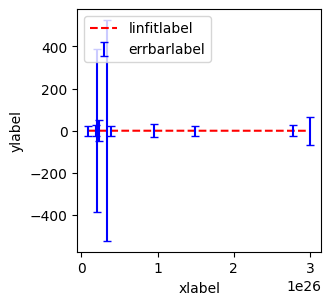

In [226]:
# SET UNCERTAINTIES
A_meas_uncertainty_guess = A_meas_uncertainty_guess # already defined above
Lambda_uncertainty_guess = 999.99 # TODO !!!

# SET UNITS
A_unit = units.rad
Lambda_unit = units.micrometer # TODO !!!

# IMPORT DATA
Lambda_meas, A1_meas, A2_meas = np.genfromtxt(os.path.join(os.getcwd(), "task2_measure_lambda_a1_a2.csv"), delimiter=',', skip_header=1, unpack=True)
A1s = np.array([u.ufloat(a1, A_meas_uncertainty_guess) for a1 in A1_meas]) *A_unit
A2s = np.array([u.ufloat(a2, A_meas_uncertainty_guess) for a2 in A2_meas]) *A_unit
Lambdas = np.array([u.ufloat(l, Lambda_uncertainty_guess) for l in Lambda_meas]) *Lambda_unit

# CALCULATE BELONGING VALUES
Nus = nu_of_lambda(Lambdas).to_base_units().to_compact()
Nu_Squareds = np.square(Nus).to_base_units().to_compact()
Delta0s = delta0_of_A1_A2(A1s, A2s).to_base_units().to_compact()
# Using Eq. 8 to figure out the refractive indexes
Etas = np.array([n_of_phi_delta0(Phi_Result.magnitude, Delta0.magnitude) for Delta0 in Delta0s]) * no_unit
Eta_Squareds = usquare(Etas)
Fs = f_of_n_squared(Eta_Squareds)

slope_withErr, intercept_withErr = errorbar_plot_with_linregress(extr_values(Nu_Squareds), extr_values(Fs), extr_sig(Fs), nolinregress=False)

# CALCULATE MATERIAL CONSTANTS FROM THE CURVE
nu0dash_Squared = intercept_withErr
nu0dash = u.wrap(np.sqrt)(nu0dash_Squared) * (1/units.s)# u.ufloat(998.38, 7.433) * (1/units.s) # TODO
A_param = (1/slope_withErr) * (1/units.s**2) # u.ufloat(848.83, 3.443) * (1/units.s**2)# TODO

# Task 3 Calculate f again with EQ 2 and compare

slope:  8.076277450752815e-28
slope_err: 0.0
intercept:  0.0


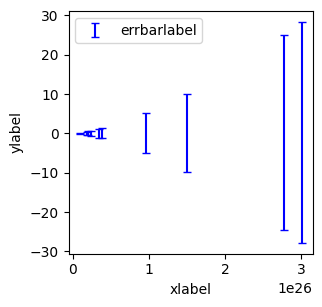

(array([0.07581090569312338+/-23.60835075617198,
        0.07613954249009906+/-23.608241008623818,
        0.5251976113716726+/-385.8982562409759,
        1.1797667404461067+/-522.5136732741312,
        0.1101807579206832+/-30.52635485126572,
        0.2548023629064507+/-67.06092737780423,
        -1.0162059386164721+/-49.75554280454016,
        -1.0042541635935989+/-25.92259508489236,
        -1.004144402391539+/-25.593859492769656,
        0.07886698750655673+/-26.99948765513838], dtype=object) <Unit('dimensionless')>,
 array([0.1209262171391832+/-9.877528563164915,
        0.031243419464969068+/-1.2994920311925335,
        0.016266709508631256+/-0.48925497084194425,
        0.027474284939134102+/-1.0719318644153724,
        0.07751928941624454+/-5.071452178575541,
        0.2425271871355366+/-28.046183867686583,
        0.01912895351181553+/-0.6234856130564796,
        0.22403074641294676+/-24.90035930523204,
        0.007361293590662811+/-0.14976000927004943,
        0.015514594626

In [227]:
# TASK 3 NOW WE USE EQ 2 AND COMPARE
Eta_Squareds__EQ2 = n_squared_of_nu(Nus, nu0dash, A_param).to_base_units().to_compact()
Etas__EQ2 = np.array([sqrt(eta_sq.to_base_units().magnitude) for eta_sq in Eta_Squareds__EQ2]) * no_unit
Fs__EQ2 = f_of_nu_squared(Nu_Squareds, nu0dash, A_param)
errorbar_plot_with_linregress(extr_values(Nu_Squareds), extr_values(Fs__EQ2), extr_sig(Fs__EQ2), nolinregress=True)

Fs, Fs__EQ2